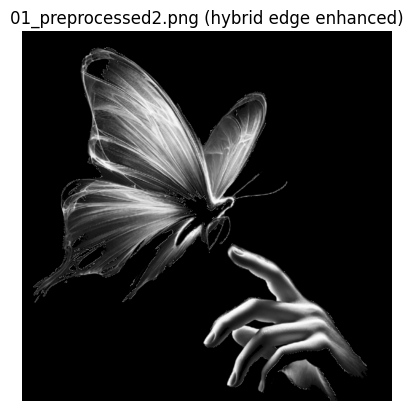

In [121]:
# Phase 1: Preprocessing
from PIL import Image, ImageOps
import numpy as np
import matplotlib.pyplot as plt

# = == Configurable Parameters ===
gamma = 1.5                 # Gamma correction factor
brightness_threshold = 20   # Brightness floor threshold (0–255)
alpha_sobel = 0     # Strength of soft enhancement
canny_boost = 255     # Brightness to add at hard edges


# === Load and Convert to Grayscale ===
input_path = "butterfly-hand-combined.jpg"
img = Image.open(input_path).convert("RGB")
gray = ImageOps.grayscale(img)
gray_np = np.array(gray).astype(np.float32)

# === Apply Gamma Correction ===
gamma_corrected = 255 * ((gray_np / 255) ** gamma)

# === Apply Brightness Threshold Floor ===
gamma_corrected[gamma_corrected < brightness_threshold] = 0
gamma_corrected = np.clip(gamma_corrected, 0, 255).astype(np.uint8)

import cv2

# === Convert gamma-corrected image to uint8 for OpenCV ===
gamma_uint8 = gamma_corrected.astype(np.uint8)

# === Compute Sobel Edge Map ===
sobel_x = cv2.Sobel(gamma_uint8, cv2.CV_64F, 1, 0, ksize=3)
sobel_y = cv2.Sobel(gamma_uint8, cv2.CV_64F, 0, 1, ksize=3)
sobel_mag = np.hypot(sobel_x, sobel_y)
sobel_mag = np.clip(sobel_mag / sobel_mag.max(), 0, 1) * 255
sobel_mag = sobel_mag.astype(np.uint8)

# === Compute Canny Edge Map ===

canny_edges = cv2.Canny(gamma_uint8, threshold1=50, threshold2=150)
canny_mask = (canny_edges > 0).astype(np.uint8)

# === Blend Both into Brightness Map ===

enhanced = gamma_uint8 + (alpha_sobel * sobel_mag).astype(np.uint8)
enhanced = np.clip(enhanced, 0, 255)
enhanced += (canny_mask * canny_boost)
enhanced = np.clip(enhanced, 0, 255)

# === Apply Brightness Threshold Floor (Post-Blend) ===
enhanced[enhanced < brightness_threshold] = 0
enhanced = enhanced.astype(np.uint8)

# === Save and Display ===
final_img = Image.fromarray(enhanced)
final_img.save("01_preprocessed2.png")

plt.imshow(final_img, cmap="gray")
plt.axis("off")
plt.title("01_preprocessed2.png (hybrid edge enhanced)")
plt.show()


Total dots after overlap filtering: 1561


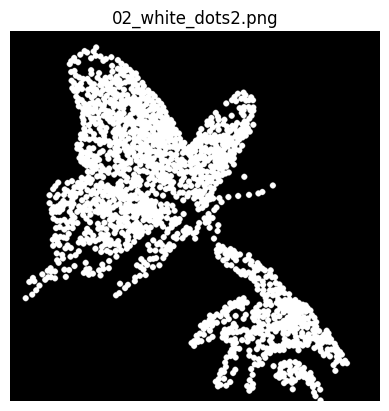

In [156]:
import random
from PIL import ImageDraw, Image
import numpy as np
import matplotlib.pyplot as plt

# === Phase 2: Dot Sampling ===

# === Configurable Parameters ===
num_dots_target = 4000        # Total number of dots to sample
dot_radius = 8                # Radius of each dot in pixels
overlap_allowed = 0.5         # e.g., allow 50% diameter overlap
delta = 1                   # Controls brightness influence (delta < 1 favors dark, >1 favors light)

# === Load Preprocessed Image ===
gray_img = Image.open("01_preprocessed2.png")
gray_np = np.array(gray_img).astype(np.float32)
height, width = gray_np.shape

# === Normalize to Probability Map and Apply Delta Curve ===
prob_map = (gray_np / 255.0) ** delta

# === Sample Dot Coordinates ===
coords = []
attempts = 0
max_attempts = num_dots_target * 10

while len(coords) < num_dots_target and attempts < max_attempts:
    x = random.randint(0, width - 1)
    y = random.randint(0, height - 1)
    if random.random() < prob_map[y, x]:
        coords.append((x, y))
    attempts += 1

# === Filter Overlapping Dots ===
def filter_overlapping(coords, dot_radius, overlap_allowed):
    min_dist = 2 * dot_radius * (1 - overlap_allowed)
    min_dist_sq = min_dist ** 2
    accepted = []

    for x, y in coords:
        too_close = False
        for ax, ay in accepted:
            dx = x - ax
            dy = y - ay
            if dx * dx + dy * dy < min_dist_sq:
                too_close = True
                break
        if not too_close:
            accepted.append((x, y))
    return accepted

# === Apply Overlap Constraint ===
coords = filter_overlapping(coords, dot_radius, overlap_allowed)
print(f"Total dots after overlap filtering: {len(coords)}")

# === Render Dots ===
dot_image = Image.new("RGB", (width, height), "black")
draw = ImageDraw.Draw(dot_image)

for x, y in coords:
    draw.ellipse(
        [(x - dot_radius, y - dot_radius), (x + dot_radius, y + dot_radius)],
        fill="white"
    )

# === Save and Preview ===
dot_image.save("02_white_dots2.png")
plt.imshow(dot_image)
plt.axis("off")
plt.title("02_white_dots2.png")
plt.show()


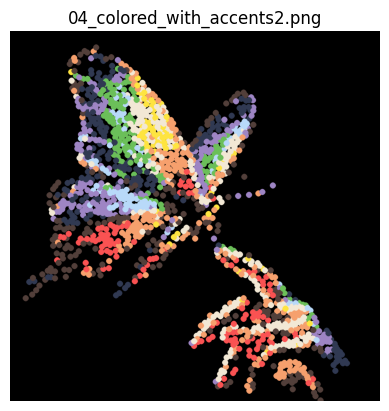

In [157]:
import colorsys

# === Configurable Parameters ===
light_thresh = 200
mid_thresh = 120
chroma_threshold = 0.1  # Below this, favor more neutral color in bin

# === Color Palette (bin-sorted) ===
color_bins = {
    'light': {
        'colors': {
            'Pale Ivory': '#F2E8D5',
            'Sky Blue': '#B8D9F9',
        }
    },
    'mid': {
        'colors': {
            'Warm Orange': '#F6A06D',
            'Lavender': '#9E85C4',
            'Muted Green': '#6BBF59',
        }
    },
    'dark': {
        'colors': {
            'Warm Brown': '#523F3A',
            'Slate Blue': '#303952',
        }
    }
}

# Convert hex to RGB (0–255) and to HSL (0–1)
def hex_to_rgb(h):
    h = h.lstrip('#')
    return tuple(int(h[i:i+2], 16) for i in (0, 2, 4))

def rgb_to_hsl(rgb):
    r, g, b = [v / 255.0 for v in rgb]
    return colorsys.rgb_to_hls(r, g, b)  # Returns (hue, lightness, saturation)

for bin_data in color_bins.values():
    color_data = []
    for name, hex_val in bin_data['colors'].items():
        rgb = hex_to_rgb(hex_val)
        h, l, s = rgb_to_hsl(rgb)
        chroma = s
        color_data.append({
            'name': name,
            'hex': hex_val,
            'rgb': rgb,
            'hue': h,
            'chroma': chroma
        })
    bin_data['colors'] = color_data

# === Load dot coordinates and original image ===
original_rgb = Image.open(input_path).convert("RGB")
dot_image = Image.new("RGB", original_rgb.size, "black")
draw = ImageDraw.Draw(dot_image)

colored_coords = []

for x, y in coords:
    x_i, y_i = int(round(x)), int(round(y))
    if not (0 <= x_i < original_rgb.width and 0 <= y_i < original_rgb.height):
        continue

    r, g, b = original_rgb.getpixel((x_i, y_i))
    lum = 0.299 * r + 0.587 * g + 0.114 * b

    # Assign tone bin
    if lum >= light_thresh:
        tone_bin = 'light'
    elif lum >= mid_thresh:
        tone_bin = 'mid'
    else:
        tone_bin = 'dark'

    h, l, s = rgb_to_hsl((r, g, b))
    chroma = s

    # Pick best match in bin
    best_color = None
    min_hue_diff = float('inf')
    for c in color_bins[tone_bin]['colors']:
        if chroma < chroma_threshold:
            best_color = min(color_bins[tone_bin]['colors'], key=lambda cc: cc['chroma'])
            break
        hue_diff = abs(h - c['hue'])
        if hue_diff > 0.5:
            hue_diff = 1.0 - hue_diff  # Wrap-around
        if hue_diff < min_hue_diff:
            min_hue_diff = hue_diff
            best_color = c

    draw.ellipse(
        [(x - dot_radius, y - dot_radius), (x + dot_radius, y + dot_radius)],
        fill=best_color['hex']
    )
    colored_coords.append((x, y, best_color['hex']))

# === Phase 4: Accent Injection ===
# Assumes: `colored_coords` from Phase 3 and `original_rgb` already loaded

# === Tunable Parameters ===
accent_chroma_threshold = 0.4
accent_luminance_min = 60
accent_luminance_max = 230
red_hue_range = [(0.95, 1.0), (0.0, 0.05)]
yellow_hue_range = [(0.12, 0.18)]

# === Accent Colors ===
accent_colors = {
    'Bright Red': '#FA5252',
    'Vivid Yellow': '#FEE440'
}

# === Hue Matching Function ===
def in_hue_range(h, ranges):
    for low, high in ranges:
        if low <= h <= high:
            return True
    return False

# === Process All Dots ===
updated_coords = []

for x, y, prev_color in colored_coords:
    x_i, y_i = int(round(x)), int(round(y))
    if not (0 <= x_i < original_rgb.width and 0 <= y_i < original_rgb.height):
        updated_coords.append((x, y, prev_color))
        continue

    r, g, b = original_rgb.getpixel((x_i, y_i))
    h, l, s = rgb_to_hsl((r, g, b))
    chroma = s
    luminance = 0.299 * r + 0.587 * g + 0.114 * b

    if (chroma > accent_chroma_threshold and 
        accent_luminance_min <= luminance <= accent_luminance_max):
        
        if in_hue_range(h, red_hue_range):
            updated_coords.append((x, y, accent_colors['Bright Red']))
            continue
        elif in_hue_range(h, yellow_hue_range):
            updated_coords.append((x, y, accent_colors['Vivid Yellow']))
            continue

    updated_coords.append((x, y, prev_color))

# === Re-render Image with Accents ===
accent_image = Image.new("RGB", original_rgb.size, "black")
draw = ImageDraw.Draw(accent_image)

for x, y, color in updated_coords:
    draw.ellipse(
        [(x - dot_radius, y - dot_radius), (x + dot_radius, y + dot_radius)],
        fill=color
    )

accent_image.save("04_colored_with_accents2.png")
plt.imshow(accent_image)
plt.axis("off")
plt.title("04_colored_with_accents2.png")
plt.show()



In [159]:
from collections import Counter

# === Count and Print Final Color Usage ===
color_counts = Counter(color for _, _, color in updated_coords)
total_dots = sum(color_counts.values())

# Map hex back to color names
hex_to_name = {v: k for k, v in {
    **{c['name']: c['hex'] for b in color_bins.values() for c in b['colors']},
    **accent_colors
}.items()}

# Print counts and percentages
print("\n=== Dot Counts by Color ===")
for hex_val, count in color_counts.most_common():
    name = hex_to_name.get(hex_val, hex_val)
    pct = 100 * count / total_dots
    print(f"{name:<15} {count:>5}  ({pct:5.2f}%)")



=== Dot Counts by Color ===
Warm Orange       254  (16.27%)
Pale Ivory        251  (16.08%)
Warm Brown        228  (14.61%)
Lavender          196  (12.56%)
Slate Blue        188  (12.04%)
Muted Green       145  ( 9.29%)
Bright Red        129  ( 8.26%)
Sky Blue          101  ( 6.47%)
Vivid Yellow       69  ( 4.42%)


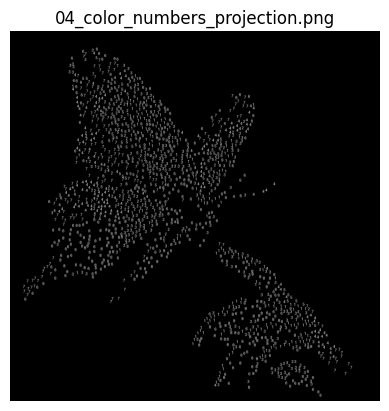

In [108]:
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt

# === Load Previous Data ===
original_rgb = Image.open(input_path).convert("RGB")

# === Color to Number Mapping ===
color_number_map = {
    '#F2E8D5': '1',  # Pale Ivory
    '#B8D9F9': '2',  # Sky Blue
    '#F6A06D': '3',  # Warm Orange
    '#9E85C4': '4',  # Lavender
    '#6BBF59': '5',  # Muted Green
    '#523F3A': '6',  # Warm Brown
    '#303952': '7',  # Slate Blue
    '#FA5252': '8',  # Bright Red
    '#FEE440': '9',  # Vivid Yellow
}

# === Create Projection Image with Numbers ===
proj_image = Image.new("RGB", original_rgb.size, "black")
draw = ImageDraw.Draw(proj_image)

# Attempt to load a reasonable font; fallback if unavailable
try:
    font = ImageFont.truetype("DejaVuSans-Bold.ttf", size=12)
except:
    font = ImageFont.load_default()

# Draw numbers
for x, y, color in updated_coords:
    label = color_number_map.get(color.upper(), '?')
    draw.text((x, y), label, fill="white", anchor="mm", font=font)

# Save and show
proj_image.save("04_color_numbers_projection.png")
plt.imshow(proj_image)
plt.axis("off")
plt.title("04_color_numbers_projection.png")
plt.show()

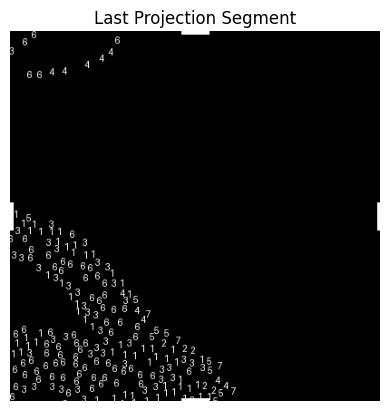

[('projection_segment_1.png', 612, 408),
 ('projection_segment_2.png', 408, 408),
 ('projection_segment_3.png', 612, 408),
 ('projection_segment_4.png', 408, 408)]

In [189]:

# === Configuration ===
grid_cols = 5  # 5 tiles across the full width
grid_rows = 5  # 5 tiles down the full height
tile_layouts = [(3, 2), (2, 2), (3, 2), (2, 2)]  # (width_in_tiles, height_in_tiles) for each output piece
input_image_path = "04_color_numbers_projection.png"

# === Load image ===
full_image = Image.open(input_image_path)
full_width, full_height = full_image.size
tile_w = full_width // grid_cols
tile_h = full_height // grid_rows

# === Create and save segments ===
segments = []
x_tiles_used = 0
y_tiles_used = 0
segment_count = 1

for layout in tile_layouts:
    tiles_wide, tiles_high = layout
    left = x_tiles_used * tile_w
    top = y_tiles_used * tile_h
    right = left + tiles_wide * tile_w
    bottom = top + tiles_high * tile_h

    # Extract subimage
    segment = full_image.crop((left, top, right, bottom))

    # Draw edge markers
    draw = ImageDraw.Draw(segment)
    bar_len = 30
    bar_thickness = 3

    # Horizontal midpoints
    mid_x = segment.width // 2
    mid_y = segment.height // 2

    # Top edge
    draw.rectangle([(mid_x - bar_len//2, 0), (mid_x + bar_len//2, bar_thickness)], fill="white")
    # Bottom edge
    draw.rectangle([(mid_x - bar_len//2, segment.height - bar_thickness),
                    (mid_x + bar_len//2, segment.height)], fill="white")
    # Left edge
    draw.rectangle([(0, mid_y - bar_len//2), (bar_thickness, mid_y + bar_len//2)], fill="white")
    # Right edge
    draw.rectangle([(segment.width - bar_thickness, mid_y - bar_len//2),
                    (segment.width, mid_y + bar_len//2)], fill="white")

    # Save segment
    filename = f"projection_segment_{segment_count}.png"
    segment.save(filename)
    segments.append((filename, segment.width, segment.height))
    segment_count += 1

    x_tiles_used += tiles_wide
    if x_tiles_used >= grid_cols:
        x_tiles_used = 0
        y_tiles_used += tiles_high

# Display last segment as confirmation
plt.imshow(segment)
plt.axis("off")
plt.title("Last Projection Segment")
plt.show()

segments


In [163]:
import json

with open("updated_coords.js", "w") as f:
    f.write("const updated_coords = ")
    f.write(json.dumps(updated_coords))
    f.write(";")


In [164]:
from PIL import Image
import numpy as np
import os

# === Input ===
input_path = "butterfly-white.png"

# === Output directory ===
os.makedirs("butterfly_colored", exist_ok=True)

# === Target colors ===
color_map = {
    'pale_ivory': '#F2E8D5',
    'sky_blue': '#B8D9F9',
    'warm_orange': '#F6A06D',
    'lavender': '#9E85C4',
    'muted_green': '#6BBF59',
    'warm_brown': '#523F3A',
    'slate_blue': '#303952',
    'bright_red': '#FA5252',
    'vivid_yellow': '#FEE440',
}

# === Helper ===
def hex_to_rgb(hex):
    h = hex.lstrip("#")
    return tuple(int(h[i:i+2], 16) for i in (0, 2, 4))

# === Load greyscale base ===
img = Image.open(input_path).convert("RGBA")
arr = np.array(img)

# === Split channels ===
gray = arr[..., 0:3].astype(np.float32) / 255.0
alpha = arr[..., 3:]

# === Generate tinted variants ===
for name, hex_color in color_map.items():
    rgb = np.array(hex_to_rgb(hex_color)) / 255.0
    tinted = (gray * rgb).clip(0, 1)
    tinted_uint8 = (tinted * 255).astype(np.uint8)

    out_arr = np.concatenate([tinted_uint8, alpha], axis=-1)
    out_img = Image.fromarray(out_arr, mode="RGBA")
    out_img.save(f"butterfly_colored/butterfly_{name}.png")
